In [511]:
"""
@Project: Connexin Group 

@FileName: pca for dimension reduction

@Author：Zhejian Peng

@Create date: Mar. 11th, 2018

@description：reduce dimension of our dataset using pca, without normalizing categorical data.

@Update date：Mar. 11th, 2018

@Vindicator：  

"""  


    

'\n@Project: Connexin Group \n\n@FileName: pca for dimension reduction\n\n@Author：Zhejian Peng\n\n@Create date: Mar. 11th, 2018\n\n@description：reduce dimension of our dataset using pca, without normalizing categorical data.\n\n@Update date：Mar. 11th, 2018\n\n@Vindicator：  \n\n'

In [512]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [513]:
def readcsv():
    LARGE_FILE = "loan_data_no_current_converted.csv"
    CHUNKSIZE = 100000 # processing 100,000 rows at a time
    # Add encoding encoding = "ISO-8859-1", why?
    reader = pd.read_csv(LARGE_FILE, chunksize=CHUNKSIZE, low_memory=False, encoding = "ISO-8859-1")
    frames = []
    for df in reader:
        frames.append(df)
    loan_data = pd.concat(frames)
    return loan_data    

In [514]:
df = readcsv()

In [515]:
# Find All the converted categorical Data

In [516]:
categorical = ['grade', 'sub_grade', 'emp_length', 'purpose', 'title', 'application_type', 'hardship_flag', 'hardship_type', 'hardship_reason', 
              'hardship_status', 'hardship_loan_status', 'settlement_status', 'disbursement_method', 'home_ownership',
              'pymnt_plan', 'debt_settlement_flag', 'title', 'initial_list_status', 'loan_status', 'verification_status',
              'term' ]

In [517]:
print("There are %d categorical data in our dataset." % len(categorical))

There are 21 categorical data in our dataset.


# Normalize Income According to zipcode 

In [518]:
# I have wrote a lot of code for this only to find out that I only need this simple function!!!
def norm_inc_by_zip(zipcode, income):
    '''
        @description: Use on a column of data; output a dictionary that returns mean and average in each zipcode area
        @zipcode： zipcode dataframe column
        @income: income df column 
        @return:      return a dictionary
    '''  
    # I try to replace nan with 0 for income, and nan in zipcode for "000xx"
    df["annual_inc"].fillna(0)
    df["zip_code"].fillna("000xx")
    
    mean_var = {}
    for idx, value in zipcode.iteritems():
        # calculate total income
        if value in mean_var:
            mean_var[value].append(income[idx])
        else:
            mean_var[value] = [income[idx]]

    
    #assert(len(zip_code) == len(mean_var))
    # compute the average income in each zip_code area
    for key, value in mean_var.items():
        # if there only one element, we set their variance to 1. This way when normalize, it will have a 0 z-score.
        if len(value) == 1:
            #print(value[0])
            mean_var[key] = [value[0], 1]
        else:
            mean_var[key] = [np.mean(value), np.std(value)]
        
    # first loop through every annual income by calculate its z score. (Income - mean_by_zipcode) / variance_by_zipcode
    for idx, value in df["zip_code"].iteritems():
        #inc_colnum = df.columns.get_loc("annual_inc")
        col_num_inc = df["annual_inc"]
        mean, std = mean_var[value]
        df.at[idx, "annual_inc"] = (df.at[idx, "annual_inc"] - mean) / std
    print("Income is successfually normalized")
    return mean_var

In [519]:
# normalize income
dic = norm_inc_by_zip(df["zip_code"], df["annual_inc"])

Income is successfually normalized


In [520]:
mv = [np.mean(df["annual_inc"]), np.var(df["annual_inc"])]
print("Mean, Variance of normalized income" , mv)

Mean, Variance of normalized income [-4.520037035772946e-15, 0.9999649508803221]


# Normalize other Features

In [521]:
#1. Drop nan columns. Info. comes from /Amy's folder/data_meaning.xlsx
# I disaggred on "funded_amount", those two are actually different
drop_col = ["id", "member_id", "url", "grade", "sub_grade", "addr_state", "funded_amnt_inv", "title", 
            "collection_recovery_fee", "collections_12_mths_ex_med", "next_pymnt_d", "recoveries", "total_pymnt",  
            "total_pymnt_inv", "total_rec_int", "desc"]
drop_col2= ["int_rate", "emp_title", "issue_d","earliest_cr_line", "last_pymnt_d", 
            "next_pymnt_d", "last_credit_pull_d", "sec_app_earliest_cr_line ", "debt_settlement_flag_date",
            "hardship_start_date", "payment_plan_start_date", "hardship_end_date", "settlement_date", "zip_code",
            "revol_util", "sec_app_earliest_cr_line"]

In [522]:
# Convert Verification_status_joint
for idx, i in df["verification_status_joint"].iteritems():
    if i == "Verified":
        df.at[idx, "verification_status_joint"] = 1
    elif i == "Source Verified":
        df.at[idx, "verification_status_joint"] = 2
    elif i == "Not Verified":
        df.at[idx, "verification_status_joint"] = 3

In [523]:
# drop the observation that was missing for any field
df.dropna(axis=0,how='all', inplace=True)
df.dropna(inplace=True,axis=1,how='all')

In [524]:
df.shape

(891823, 142)

In [525]:
# Drop drop_col, drop_col2
df.drop(drop_col, inplace=True, axis=1, errors='ignore')
df.drop(drop_col2, inplace=True, axis=1, errors='ignore')


In [526]:
df.shape

(891823, 115)

In [527]:
df.fillna(0, inplace=True)

In [528]:
# Select features that is not in categorical data to normalize: categorial[], verification_status_joint, and annual_inc
features= list(df.columns)
features_need_norm = []
categorical_features = []
for i in features:
    if i not in categorical and i != "verification_status_joint" and i != "annual_inc":
        features_need_norm.append(i)
    else:
        categorical_features.append(i)



In [529]:
print("There are %d numerical features need normalization" %len(features_need_norm))

There are 96 numerical features need normalization


In [530]:
Y = df.loc[:,['loan_status']].values
features.remove("loan_status")
categorical_features.remove('loan_status')

In [531]:
# We can not have loan_status in X, we want to check this, if it prints "Warning", we have a problem!!!
for i in categorical_features:
    if i == "loan_status":
        print("Warning!")
for i in features_need_norm:
    if i == "loan_status":
        print("Warning!")


In [532]:
len(features_need_norm)

96

In [533]:
# Choice all features in features_need_norm list and normalize it and store it to normalized_features
# There should be 96 features need normalization
normalized_features = df.loc[:,features_need_norm].values
normalized_features = StandardScaler().fit_transform(normalized_features)

In [534]:
X = normalized_features

In [535]:
# Add features to X normalized and categorical, concatenate 
# Elimiate loan_status from categorical_features, because we dont want 
X = np.concatenate((X, df.loc[:,categorical_features].values), axis=1)

# Performing PCA Analysis
    @Comments: 
    1. Compares to previous result when I try to normalize categorical data, without normalizing categorical data     works much better:
    -- Previous PCA Result: 
    
    The percentage of Variance retained by K =  30  :  0.761407465408
    The percentage of Variance retained by K =  40  :  0.8371853523
    The percentage of Variance retained by K =  50  :  0.894559622941
    The percentage of Variance retained by K =  60  :  0.936803380943
    The percentage of Variance retained by K =  70  :  0.964525576084
    The percentage of Variance retained by K =  80  :  0.983301266634

    -- New PCA Result:
    The percentage of Variance retained by K =  30  :  0.809492859764
    The percentage of Variance retained by K =  40  :  0.872392858617
    The percentage of Variance retained by K =  50  :  0.919855783682
    The percentage of Variance retained by K =  60  :  0.953081439718
    The percentage of Variance retained by K =  70  :  0.975445377574
    The percentage of Variance retained by K =  80  :  0.990303107118
    The percentage of Variance retained by K =  90  :  0.997617699656

In [536]:
def pca_k(k):
    '''
    @ Function: Print the percentage variance retained by fisrt K components
    @ Parameters: 
                k -- the number of principal components
    @ Return: Void
    '''
    pca = PCA(n_components=k)
    principalComponents = pca.fit_transform(X)
    #principalDf = pd.DataFrame(data = principalComponents)
    pca.explained_variance_ratio_
    print("The percentage of Variance retained by K = ",k, " : ", sum(pca.explained_variance_ratio_))
    return pca

In [537]:
test_k = [30,40,50,60,70,80,90]

In [538]:
for k in test_k:
    pca_k(k)

The percentage of Variance retained by K =  30  :  0.809680646398
The percentage of Variance retained by K =  40  :  0.872249575529
The percentage of Variance retained by K =  50  :  0.919806402454
The percentage of Variance retained by K =  60  :  0.953043647036
The percentage of Variance retained by K =  70  :  0.975425636285
The percentage of Variance retained by K =  80  :  0.990302341596
The percentage of Variance retained by K =  90  :  0.997617699839


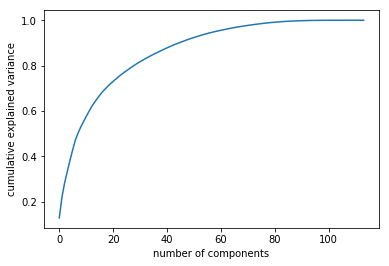

In [539]:
# Show the result in a plt, as number of componets in
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# Run Logistic Regression on PCA Variables:
-- Now we choice k = 80 compoents to fit the model using logistic regression

In [540]:
class log_reg():
    # Evaluate the model by splitting into train and test sets
    def split(x,y,rand=0):
        
        y = np.ravel(y)
        x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25,random_state=rand)
        
        return x_train, x_test, y_train, y_test 
    #we need to add validation dataset here
    
    # Find binary column method one
    def bool_cols(df,isbool=True):
        bool_cols=[]
        for col in df:
            if isbool==True:
                if df[col].dropna().value_counts().index.isin([0,1]).all():
                    bool_cols.append(col)
            else:
                if not df[col].dropna().value_counts().index.isin([0,1]).all():
                    bool_cols.append(col)
        return bool_cols
    # this above step is to facilitate normalization later
    # method two
    def not_bi(x):
        not_bi=[]
        for i in list(x):
            u=x[i].unique()
            if not (0 in u and 1 in u and len(u)==2): #if not binary
                not_bi.append(i)
        return not_bi
    
    def reg(x_train, y_train):
           
        model = LogisticRegression(penalty='l2',class_weight='balanced',solver='sag',n_jobs=-1)
        
        """
        Why we need standardize?
        
        Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features 
        with approximately the same scale. You can preprocess the data with 
        a scaler from sklearn.preprocessing.
        """
        
        model = model.fit(x_train, y_train)
        
        return model
    
    def ModelValuation(x_test,y_test,model):
        
        probs = model.predict_proba(x_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:, 1])
        
        plt.figure(1)
        plt.plot(fpr, tpr, label='LogisticRegression')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()
        
        print("Area Under the Curve (AUC) from prediction score is %f" % metrics.roc_auc_score(y_test, probs[:, 1]))
    
        return None  
    
    def y_pred(x_test,threshold=0.5):
        
        if threshold == 0.5:
            y_predicted = model.predict(x_test)
        else:
            probs = model.predict_proba(x_test)
            y_predicted = np.array(probs[:,1] >= threshold).astype(int)
        
        return y_predicted    
    
    def GetScores(y_test,y_predicted):
        #G means score 
        CM = metrics.confusion_matrix(y_test, y_predicted)
        TN = CM[0,0]
        FN = CM[1,0]
        TP = CM[1,1]
        FP = CM[0,1]
        
        sensitivity = float(TP)/float(TP+FN)
        specificity = float(TN)/float(TN+FP)
        G = np.sqrt(sensitivity*specificity)
        print("G score is %f" % G)
        print("Specificity is %f" % specificity)
        
        # Generate and display different evaluation metrics
        print("Mean accuracy score is %f" % metrics.accuracy_score(y_test, y_predicted))
          
        print("Confusion Marix")
        print(CM)
        
        return specificity , G
        
    # Convenience function to plot confusion matrix
    def confusion(y_test,y_predicted,title):
        
        # Define names for the three Iris types
        names = ['Default', 'Not Default']
    
        # Make a 2D histogram from the test and result arrays
        pts, xe, ye = np.histogram2d(y_test, y_predicted, bins=2)
    
        # For simplicity we create a new DataFrame
        pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
        
        # Display heatmap and add decorations
        hm = sns.heatmap(pd_pts, annot=True, fmt="d")
        hm.axes.set_title(title)
        
        return None
            
    def find_threshold(x_test,y_test):
    
        probs = model.predict_proba(x_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:, 1])
        
        sensitivity = tpr
        specificity = 1 - fpr
        G = np.sqrt(sensitivity*specificity)
        
        plt.figure(2)
        plt.plot(thresholds,G)
        plt.xlabel('Thresholds')
        plt.ylabel('G-Scores')
        plt.title('G-Scores with different thresholds')
        plt.show()
        
        
        print("The highest G score is %f with threshold at %f" % (np.amax(G),thresholds[np.argmax(G)]) )
        
        return thresholds[np.argmax(G)]

In [541]:
pca_k_80 = pca_k(80)

The percentage of Variance retained by K =  80  :  0.990303137314


In [542]:
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

logistic = linear_model.LogisticRegression()

In [543]:
logistic = linear_model.LogisticRegression()


pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

In [544]:
# Let's test our result previous result, Previous result set Y to binary number 1,2.
'''
    elif i == "Default":
        loan_data.at[idx, "loan_status"] = 7
    elif i == "Charged Off":
        loan_data.at[idx, "loan_status"] = 8
'''
Y = list(Y.reshape(len(Y)))
for i in range(len(Y)):
    if Y[i] == 7 or Y[i] ==8:
        Y[i] = 1
    else:
        Y[i] = 0

Text(0,0.5,'explained_variance_')

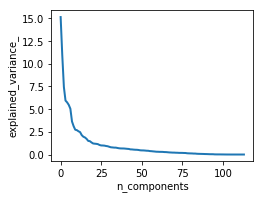

In [545]:
# Plot the PCA spectrum
pca.fit(X)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [546]:
# apply K = 80 pca to original dataset
X_transformed_pca = pca_k_80.fit_transform(X)

In [547]:
# split train test set uing X_transformed_pca
x_train, x_test, y_train, y_test = log_reg.split(X_transformed_pca,Y,rand=None)

In [548]:
model = log_reg.reg(x_train,y_train)

/Users/zhejianpeng/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


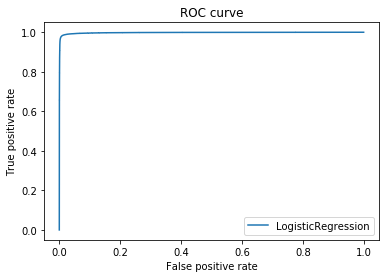

Area Under the Curve (AUC) from prediction score is 0.997886


In [549]:
log_reg.ModelValuation(x_test,y_test,model)

In [550]:
y_predicted = log_reg.y_pred(x_test,threshold=0.5)

G score is 0.983358
Specificity is 0.995939
Mean accuracy score is 0.991012
Confusion Marix
[[178292    727]
 [  1277  42660]]


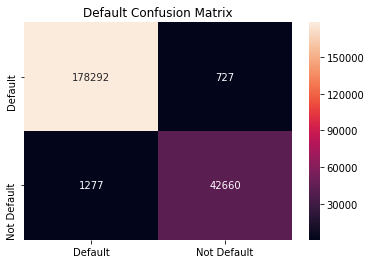

In [551]:
spec , G = log_reg.GetScores(y_test,y_predicted)
log_reg.confusion(y_test,y_predicted,'Default Confusion Matrix')

In [552]:
y_test.shape

(222956,)